# 使用keras训练模型

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## 模型的构造、训练、测试流程

In [2]:
# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, './ch3/net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3,
         validation_data=(x_val, y_val))
print('history:')
# history 打印训练过程的相关数据
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)

pred = model.predict(x_test[:2])
print('predict:')
print(pred)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 31us/sample - loss: 0.3454 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.1893 - val_sparse_categorical_accuracy: 0.9439
Epoch 2/3
50000/50000 [==============================] - 1s 26us/sample - loss: 0.1578 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9599
Epoch 3/3
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1149 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1190 - val_sparse_categorical_accuracy: 0.9667
history:
{'loss': [0.3453949404430389, 0.15779645699739456, 0.11487457281351089], 'sparse_categorical_accuracy': [0.90156, 0.95248, 0.96502], 'val_loss': [0.18934509282112122, 0.13633859026432038, 0.11897836507558823], 'val_sparse_categorical_accuracy': [0.9439, 0.9599, 0.9667]}
10000/10000 [==============================] - 0s 9us/sample - loss: 0.1238 - sparse_categorical_accuracy: 0.963

## 自定义损失和指标

自定义指标只需继承 Metric 类， 并重写一下函数

_init_(self)，初始化。

update_state(self，y_true，y_pred，sample_weight = None)，它使用目标 y_true 和模型预测 y_pred 来更新状态变量。

result(self)，它使用状态变量来计算最终结果。

reset_states(self)，重新初始化度量的状态。

In [3]:
# 这是一个简单的示例，显示如何实现 CatgoricalTruePositives 指标，该指标计算正确分类为属于给定类的样本数量

class CatgoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CatgoricalTruePostives, self).__init__(name=name, **kwargs)
        self.true_postives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))

        y_true = tf.cast(y_true, tf.float32)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)

        return self.true_postives.assign_add(tf.reduce_sum(y_true))

    def result(self):
        return tf.identity(self.true_postives)

    def reset_states(self):
        self.true_postives.assign(0.)


model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CatgoricalTruePostives()])

model.fit(x_train, y_train,
         batch_size=64, epochs=3)

Epoch 1/3
50000/50000 [==============================] - 1s 26us/sample - loss: 0.0918 - binary_true_postives: 7645.0000
Epoch 2/3
50000/50000 [==============================] - 1s 23us/sample - loss: 0.0763 - binary_true_postives: 7834.0000
Epoch 3/3
50000/50000 [==============================] - 1s 23us/sample - loss: 0.0641 - binary_true_postives: 8405.0000


In [4]:
# 以定义网络层的方式添加网络 loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 46us/sample - loss: 2.3610 - sparse_categorical_accuracy: 0.1128


In [5]:
# 也可以以定义网络层的方式添加要统计的 metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')

        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 47us/sample - loss: 0.3045 - sparse_categorical_accuracy: 0.9114 - std_of_activation: 0.9775


In [6]:
# 也可以直接在 model 上面加
# 也可以以定义网络层的方式添加要统计的 metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')

        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)

model.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')

model.add_loss(tf.reduce_sum(h1)*0.1)

# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 47us/sample - loss: 2.3542 - sparse_categorical_accuracy: 0.1131 - std_of_activation: 0.3083


处理使用 validation_data 传入测试数据，还可以使用 validation_split 划分验证数据

ps: validation_split 只能在用 numpy 数据训练的情况下使用

In [7]:
# 处理使用 validation_data 传入测试数据，还可以使用 validation_split 划分验证数据
model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 2s 55us/sample - loss: 2.3014 - sparse_categorical_accuracy: 0.1141 - std_of_activation: 0.3087 - val_loss: 2.3014 - val_sparse_categorical_accuracy: 0.1115 - val_std_of_activation: 0.3066


## 使用tf.data构造数据

In [8]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model = get_compiled_model()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)

Epoch 1/3
100/100 [==============================] - 1s 7ms/step - loss: 0.7608 - sparse_categorical_accuracy: 0.8061 - val_loss: 0.4052 - val_sparse_categorical_accuracy: 0.8646
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.3210 - val_sparse_categorical_accuracy: 0.9010
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3179 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.2337 - val_sparse_categorical_accuracy: 0.9167


## 样本权重和类权重

“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是 1 和 0 时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重” dict 是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类 “0” 比数据中的类 “1” 少两倍，则可以使用 class_weight = {0：1.，1：0.5}。

In [9]:
# 增加第5类的权重
import numpy as np

# 类权重
model = get_compiled_model()

class_weight = {i : 1.0 for i in range(10)}
class_weight[5] = 2.0
print(class_weight)

model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Epoch 1/4
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3686 - sparse_categorical_accuracy: 0.90330s - loss: 0.4617 - sparse_categorical_accura
Epoch 2/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1700 - sparse_categorical_accuracy: 0.9523
Epoch 3/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1242 - sparse_categorical_accuracy: 0.9655
Epoch 4/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.0987 - sparse_categorical_accuracy: 0.9720


In [10]:
# 样本权重
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)

Epoch 1/4
50000/50000 [==============================] - 1s 25us/sample - loss: 0.3691 - sparse_categorical_accuracy: 0.9021
Epoch 2/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1665 - sparse_categorical_accuracy: 0.9531
Epoch 3/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1222 - sparse_categorical_accuracy: 0.9653
Epoch 4/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.0981 - sparse_categorical_accuracy: 0.9715


In [11]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

Epoch 1/3
782/782 [==============================] - 2s 3ms/step - loss: 0.3733 - sparse_categorical_accuracy: 0.9006
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9528
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9651


## 多输入多输出模型

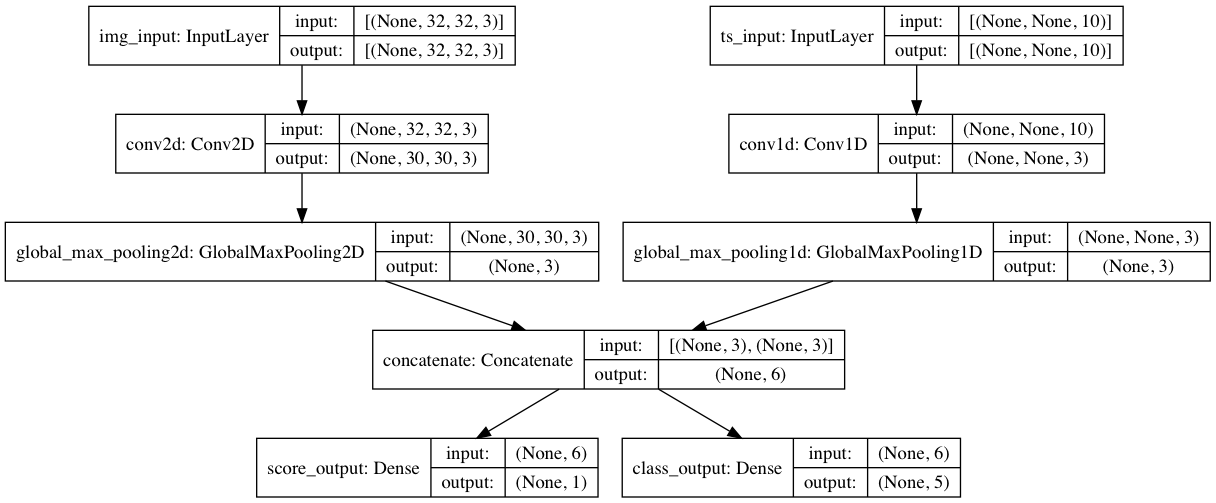

In [12]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])
keras.utils.plot_model(model, './ch3/multi_input_output_model.png'
                       , show_shapes=True)

In [13]:
# 可以为模型指定不同的 loss和 metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 还可以指定 loss 的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weight={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的 loss 置 0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

W0829 11:01:47.104783 140735620006784 training_utils.py:1152] Output score_output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to score_output.


## 使用回调

Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

- 在训练期间的不同时间点进行验证（超出内置的每个时期验证）
- 定期检查模型是否超过某个精度阈值
- 在训练似乎平稳时改变模型的学习率
- 在训练似乎平稳时对顶层进行微调
- 在训练结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。


**可使用的内置回调有**

- ModelCheckpoint：定期保存模型。
- EarlyStopping：当训练不再改进验证指标时停止训练。
- TensorBoard：定期编写可在 TensorBoard 中显示的模型日志（更多细节见“可视化”）。
- CSVLogger：将损失和指标数据流式传输到 CSV 文件。
- 等等

### 回调的使用

In [14]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)]

model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 1s 32us/sample - loss: 0.3610 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.2446 - val_sparse_categorical_accuracy: 0.9255
Epoch 2/20
40000/40000 [==============================] - 1s 29us/sample - loss: 0.1688 - sparse_categorical_accuracy: 0.9502 - val_loss: 0.1805 - val_sparse_categorical_accuracy: 0.9458
Epoch 3/20
40000/40000 [==============================] - 1s 27us/sample - loss: 0.1221 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.1528 - val_sparse_categorical_accuracy: 0.9550
Epoch 4/20
40000/40000 [==============================] - 1s 28us/sample - loss: 0.0968 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1422 - val_sparse_categorical_accuracy: 0.9599
Epoch 5/20
40000/40000 [==============================] - 1s 28us/sample - loss: 0.0798 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.1364 - val_sparse_categorical_accuracy: 0.9597
Epoch 6/20
4000

In [15]:
# checkpoint模型回调
model = get_compiled_model()
check_callback = keras.callbacks.ModelCheckpoint(
    filepath='./ch3/mymodel_{epoch}.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
38464/40000 [===========================>..] - ETA: 0s - loss: 0.3856 - sparse_categorical_accuracy: 0.8912
Epoch 00001: val_loss improved from inf to 0.22007, saving model to ./ch3/mymodel_1.h5
40000/40000 [==============================] - 1s 33us/sample - loss: 0.3796 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2201 - val_sparse_categorical_accuracy: 0.9329
Epoch 2/3
39168/40000 [============================>.] - ETA: 0s - loss: 0.1750 - sparse_categorical_accuracy: 0.9489- ETA: 0s - loss: 0.1937 - sparse_categorical_ac
Epoch 00002: val_loss improved from 0.22007 to 0.17010, saving model to ./ch3/mymodel_2.h5
40000/40000 [==============================] - 1s 28us/sample - loss: 0.1743 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1701 - val_sparse_categorical_accuracy: 0.9478
Epoch 3/3
39296/40000 [============================>.] - ETA: 0s - loss: 0.1293 - sparse_categorical_accuracy: 0.9622- ETA: 0s - loss: 0

**如果遇到报错： `ImportError: 'load_weights' requires h5py.` 则可以 `conda uninstall h5py`, 然后重装 `pip install h5py`**

In [16]:
# 动态调整学习率
initial_learning_rate = 0.1

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [17]:
# 使用tensorboard
import os

tensorboard_cbk = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(), 'ch3'))

model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 1s 28us/sample - loss: 0.1037 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1504 - val_sparse_categorical_accuracy: 0.9547
Epoch 2/5
40000/40000 [==============================] - 1s 28us/sample - loss: 0.0858 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.1455 - val_sparse_categorical_accuracy: 0.9561
Epoch 3/5
40000/40000 [==============================] - 1s 27us/sample - loss: 0.0721 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.1381 - val_sparse_categorical_accuracy: 0.9608
Epoch 4/5
40000/40000 [==============================] - 1s 27us/sample - loss: 0.0625 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.1364 - val_sparse_categorical_accuracy: 0.9630
Epoch 5/5
40000/40000 [==============================] - 1s 27us/sample - loss: 0.0528 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.1547 - val_sparse_categorical_accuracy: 0.9575


### 创建自己的回调方法

In [18]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:', self.losses[-1])
        
model = get_compiled_model()

callbacks = [LossHistory()]

model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
37888/40000 [===========================>..] - ETA: 0s - loss: 0.3668 - sparse_categorical_accuracy: 0.8973
loss: 0.357725568240881
40000/40000 [==============================] - 1s 32us/sample - loss: 0.3577 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.2208 - val_sparse_categorical_accuracy: 0.9355
Epoch 2/3
39744/40000 [============================>.] - ETA: 0s - loss: 0.1718 - sparse_categorical_accuracy: 0.9495
loss: 0.1715343112438917
40000/40000 [==============================] - 1s 28us/sample - loss: 0.1715 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1673 - val_sparse_categorical_accuracy: 0.9485
Epoch 3/3
39040/40000 [============================>.] - ETA: 0s - loss: 0.1257 - sparse_categorical_accuracy: 0.9628
loss: 0.12591686638593674
40000/40000 [==============================] - 1s 28us/sample - loss: 0.1259 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 

## 自己构造训练和验证循环

In [19]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 自己构造循环
for epoch in range(3):
    print('epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # 开一个gradient tape, 计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            
            loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

epoch:  0
Training loss (for one batch) at step 0: 2.334444999694824
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2195186614990234
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.1388564109802246
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.1101131439208984
Seen so far: 38464 samples
epoch:  1
Training loss (for one batch) at step 0: 2.018697500228882
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9181092977523804
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.7415821552276611
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7942681312561035
Seen so far: 38464 samples
epoch:  2
Training loss (for one batch) at step 0: 1.6607942581176758
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5221712589263916
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.289088487625122
Seen so far: 25664 samples
Training 

In [23]:
# 训练并验证
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# Iterate over epochs.
for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Update training metric.
        train_acc_metric(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, loss_value))
            print('Seen so far: %s samples' % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: tf.Tensor(2.3467674, shape=(), dtype=float32)
Seen so far: 64 samples
Training loss (for one batch) at step 200: tf.Tensor(2.263164, shape=(), dtype=float32)
Seen so far: 12864 samples
Training loss (for one batch) at step 400: tf.Tensor(2.177899, shape=(), dtype=float32)
Seen so far: 25664 samples
Training loss (for one batch) at step 600: tf.Tensor(2.1017227, shape=(), dtype=float32)
Seen so far: 38464 samples
Training acc over epoch: 0.2376600056886673
Validation acc: 0.4058000147342682
Start of epoch 1
Training loss (for one batch) at step 0: tf.Tensor(2.0571954, shape=(), dtype=float32)
Seen so far: 64 samples
Training loss (for one batch) at step 200: tf.Tensor(1.8929907, shape=(), dtype=float32)
Seen so far: 12864 samples
Training loss (for one batch) at step 400: tf.Tensor(1.8322653, shape=(), dtype=float32)
Seen so far: 25664 samples
Training loss (for one batch) at step 600: tf.Tensor(1.7300646, shape=(), dtype=float32

In [24]:
# 添加自己构造的 loss, 每次只能看到最新一次训练增加的 loss
class ActivityRegularizationLayer(layers.Layer):
  
  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs
  
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)

[<tf.Tensor: id=1353997, shape=(), dtype=float32, numpy=6.448087>]
[<tf.Tensor: id=1354058, shape=(), dtype=float32, numpy=6.5252285>]


In [25]:
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)

            # Add extra losses created during this forward pass:
            loss_value += sum(model.losses)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 9.146984100341797
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.469130754470825
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3822920322418213
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3377926349639893
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3572325706481934
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3209803104400635
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.320786476135254
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3142898082733154
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.3235599994659424
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.309755325317383
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3114914894104004
Seen so far: 256